## Timeseries clustering

Time series clustering is to partition time series data into groups based on similarity or distance, so that time series in the same cluster are similar.

Methodology followed:
* Use Variational Recurrent AutoEncoder (VRAE) for dimensionality reduction of the timeseries
* To visualize the clusters, PCA and t-sne are used

Paper:
https://arxiv.org/pdf/1412.6581.pdf

#### Contents

0. [Load data and preprocess](#Load-data-and-preprocess)
1. [Initialize VRAE object](#Initialize-VRAE-object)
2. [Fit the model onto dataset](#Fit-the-model-onto-dataset)
3. [Transform the input timeseries to encoded latent vectors](#Transform-the-input-timeseries-to-encoded-latent-vectors)
4. [Save the model to be fetched later](#Save-the-model-to-be-fetched-later)
5. [Visualize using PCA and tSNE](#Visualize-using-PCA-and-tSNE)

In [379]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Import required modules

In [393]:
from vrae.vrae import VRAE
from vrae.utils import *
import numpy as np
import torch
import pickle

import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download dir

In [387]:
dload = './model_dir'

### Hyper parameters

In [394]:
seq_len = 10
hidden_size = 256
hidden_layer_depth = 3
latent_length = 32
batch_size = 32
learning_rate = 0.00002
n_epochs = 2000
dropout_rate = 0.0
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=10
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Load data and preprocess

In [530]:
#X_train, X_val, y_train, y_val = open_data('data', ratio_train=1.0, dataset='EMG', filename = "EMGe5_len10")

do_pca = True

X_train, y_train = open_data_nosplit('data', dataset='EMG', filename = "EMGe57_len10")
print(f'training dataset shape: {X_train.shape}')
print(f'training dataset shape: {y_train.shape}')


# Data is sequential, so we need to reshape it to add a time dimension
X_train = X_train.reshape(X_train.shape[0], seq_len, -1)
# print(f'training dataset shape: {X_train.shape}')

# cut the last several segments to match batch size
num_seg = (X_train.shape[0] // batch_size) * batch_size
X_train = X_train[:num_seg, :, :]

print(f'training dataset shape: {X_train.shape}')

if do_pca:
    # Copy original training data
    X_train_ori = np.copy(X_train)
#     print(X_train_ori.shape)
    
    # Explained variance
    temp = X_train.reshape(-1, X_train.shape[2])
    print(f'training dataset shape: {X_train.shape}')
    X_pca = PCA(n_components=15).fit(temp)
    print(f'Explained variance ratio: {np.cumsum(X_pca.explained_variance_ratio_)}')
    
    # Need to specify N_components inside pca for later reconstruction
    X_pca = PCA(n_components=6).fit(temp)
    X_train = X_pca.transform(temp)
#     print(f'training dataset shape: {X_train.shape}')
    X_train = X_train.reshape(-1, seq_len, 6)
print(f'Training dataset shape: {X_train.shape}')
    
train_dataset = TensorDataset(torch.from_numpy(X_train))
# test_dataset = TensorDataset(torch.from_numpy(X_train))
number_of_features = X_train.shape[2]

# num_classes = len(np.unique(y_train))
# base = np.min(y_train)  # Check if data is 0-based
# if base != 0:
#     y_train -= base
y_train = y_train[:num_seg, :]
print(f'Training label: {np.unique(y_train)}, shape: {y_train.shape}')

training dataset shape: (17997, 150, 1)
training dataset shape: (17997, 1)
training dataset shape: (17984, 150, 1)


ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [529]:
aaaa = np.ones((3,1))
bbbb = np.ones((7,1))
cccc = np.concatenate([aaaa,bbbb, aaaa], axis = 0)
cccc.shape

(13, 1)

In [496]:
X_test, y_test = open_data_nosplit('data', dataset='EMG', filename = "EMG1_len10")

# Data is sequential, so we need to reshape it to add a time dimension
X_test = X_test.reshape(X_test.shape[0], seq_len, -1)

# cut the last several segments to match batch size
# num_seg = (X_train.shape[0] // batch_size) * batch_size
# X_train = X_train[:num_seg, :, :]
print(f'Testing dataset shape: {X_test.shape}')

# train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_test))
# number_of_features = X_train.shape[2]

print(f'Testing label: {np.unique(y_test)}, shape: {y_test.shape}')

Testing dataset shape: (3599, 10, 15)
Testing label: [-1.  0.  1.  2.  3.], shape: (3599, 1)


### Initialize VRAE object

VRAE inherits from `sklearn.base.BaseEstimator` and overrides `fit`, `transform` and `fit_transform` functions, similar to sklearn modules

In [395]:
vrae = VRAE(sequence_length=seq_len,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

### Fit the model onto dataset

In [396]:
#vrae.fit(train_dataset)

#If the model has to be saved, with the learnt parameters use:
vrae.fit(train_dataset)

Epoch: 9
Average loss: 3625441.6910
Epoch: 19
Average loss: 2870399.1388
Epoch: 29
Average loss: 2306443.2984
Epoch: 39
Average loss: 1888174.6090
Epoch: 49
Average loss: 1554341.3410
Epoch: 59
Average loss: 1283287.2839
Epoch: 69
Average loss: 1069197.7502
Epoch: 79
Average loss: 898341.8783
Epoch: 89
Average loss: 759337.8039
Epoch: 99
Average loss: 645237.8334
Epoch: 109
Average loss: 557506.2401
Epoch: 119
Average loss: 490610.1833
Epoch: 129
Average loss: 439498.1182
Epoch: 139
Average loss: 399920.6993
Epoch: 149
Average loss: 364668.6853
Epoch: 159
Average loss: 334016.0035
Epoch: 169
Average loss: 309252.3222
Epoch: 179
Average loss: 287776.4173
Epoch: 189
Average loss: 270109.0248
Epoch: 199
Average loss: 255739.4042
Epoch: 209
Average loss: 243316.8566
Epoch: 219
Average loss: 229449.8271
Epoch: 229
Average loss: 216724.0949
Epoch: 239
Average loss: 206243.7300
Epoch: 249
Average loss: 197811.9977
Epoch: 259
Average loss: 190221.4643
Epoch: 269
Average loss: 182914.5998
Epoch

### Plot loss

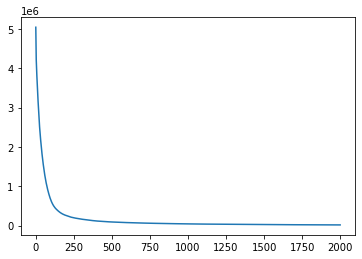

In [397]:
plt.plot(vrae.all_loss)

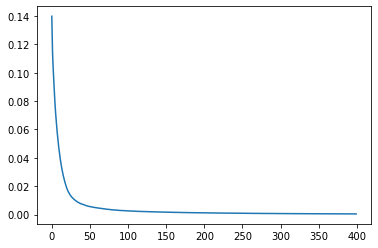

In [398]:
plt.plot(vrae.rec_mse)

### Transform the input timeseries to encoded latent vectors

In [399]:
#If the latent vectors have to be saved, pass the parameter `save`
z_run = vrae.transform(train_dataset, save = True, filename = 'z_run_e57pca_2000epoch.pkl')
z_run.shape

(17984, 32)

### Save / load the model

In [400]:
vrae.save('./vrae_e57pca_2000epoch.pth')

In [218]:
vrae.load(dload+'/vrae_3_10000epoch.pth')
with open(dload+'/z_run.pkl', 'rb') as fh:
    z_run = pickle.load(fh)

### Reconstruction

In [509]:
reconstruction = vrae.reconstruct(train_dataset)
reconstruction = reconstruction.transpose((1,0,2))

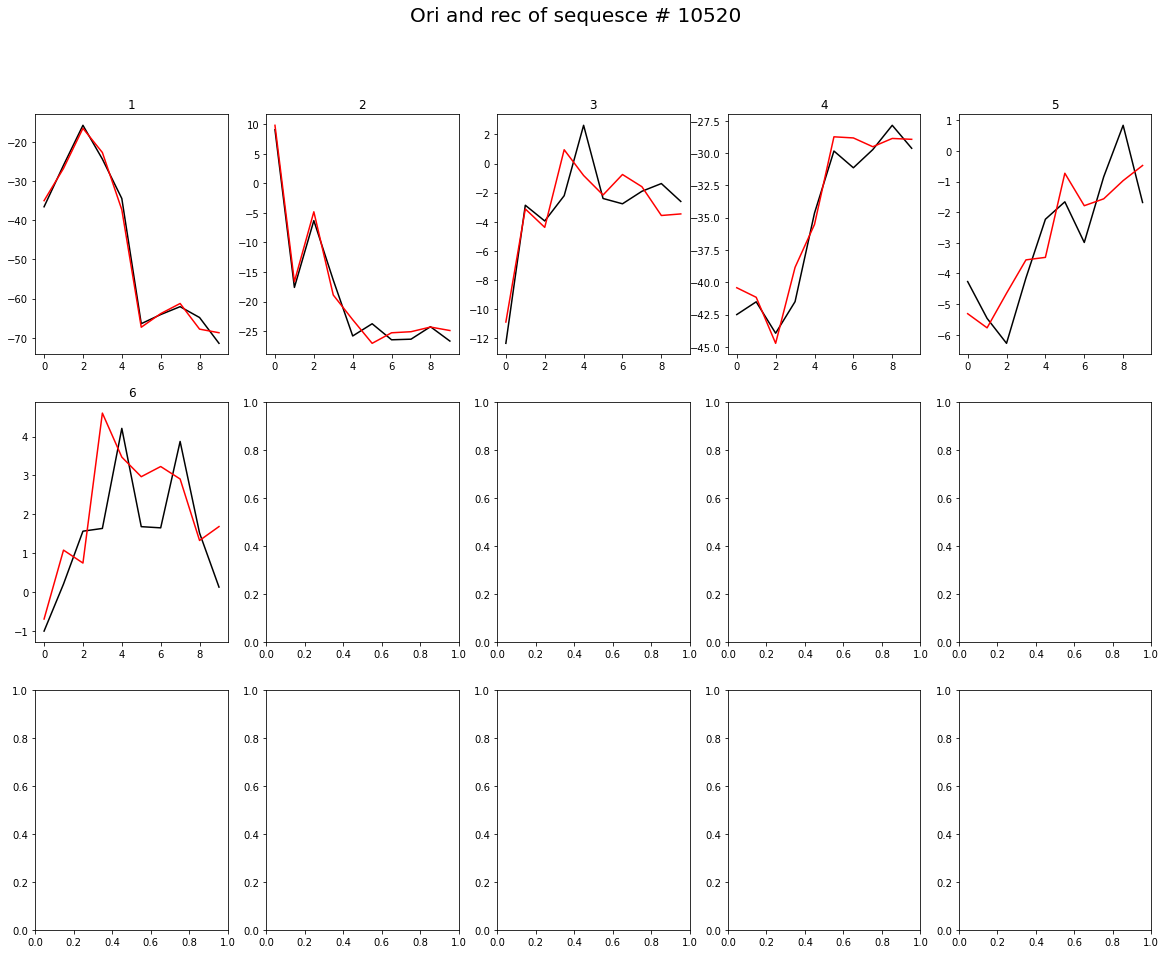

In [428]:
# Show one reconstruction

num_seq = reconstruction.shape[0]

fig, axs = plt.subplots(3, 5, figsize = (20, 15))
idx = np.random.choice(num_seq, 1)[0]
# idx = 250

for ii in range(number_of_features):
    ori = X_train[idx, :, ii]
    rec = reconstruction[idx, :, ii]
    axs[ii//5, ii%5].plot(ori, color = 'black')
    axs[ii//5, ii%5].plot(rec, color = 'red')
    axs[ii//5, ii%5].set_title(ii+1)
fig.suptitle(f'Ori and rec of sequesce # {idx+1}', size = 20)
plt.show()
    

In [471]:
corr = []
# num_seq
for ii in range(number_of_features):
    temp = []
    for jj in range(num_seq):
        corr_temp = np.corrcoef(reconstruction[jj, :, ii], X_train[jj, :, ii])[0,1]
        temp.append(corr_temp)
    corr.append(temp)

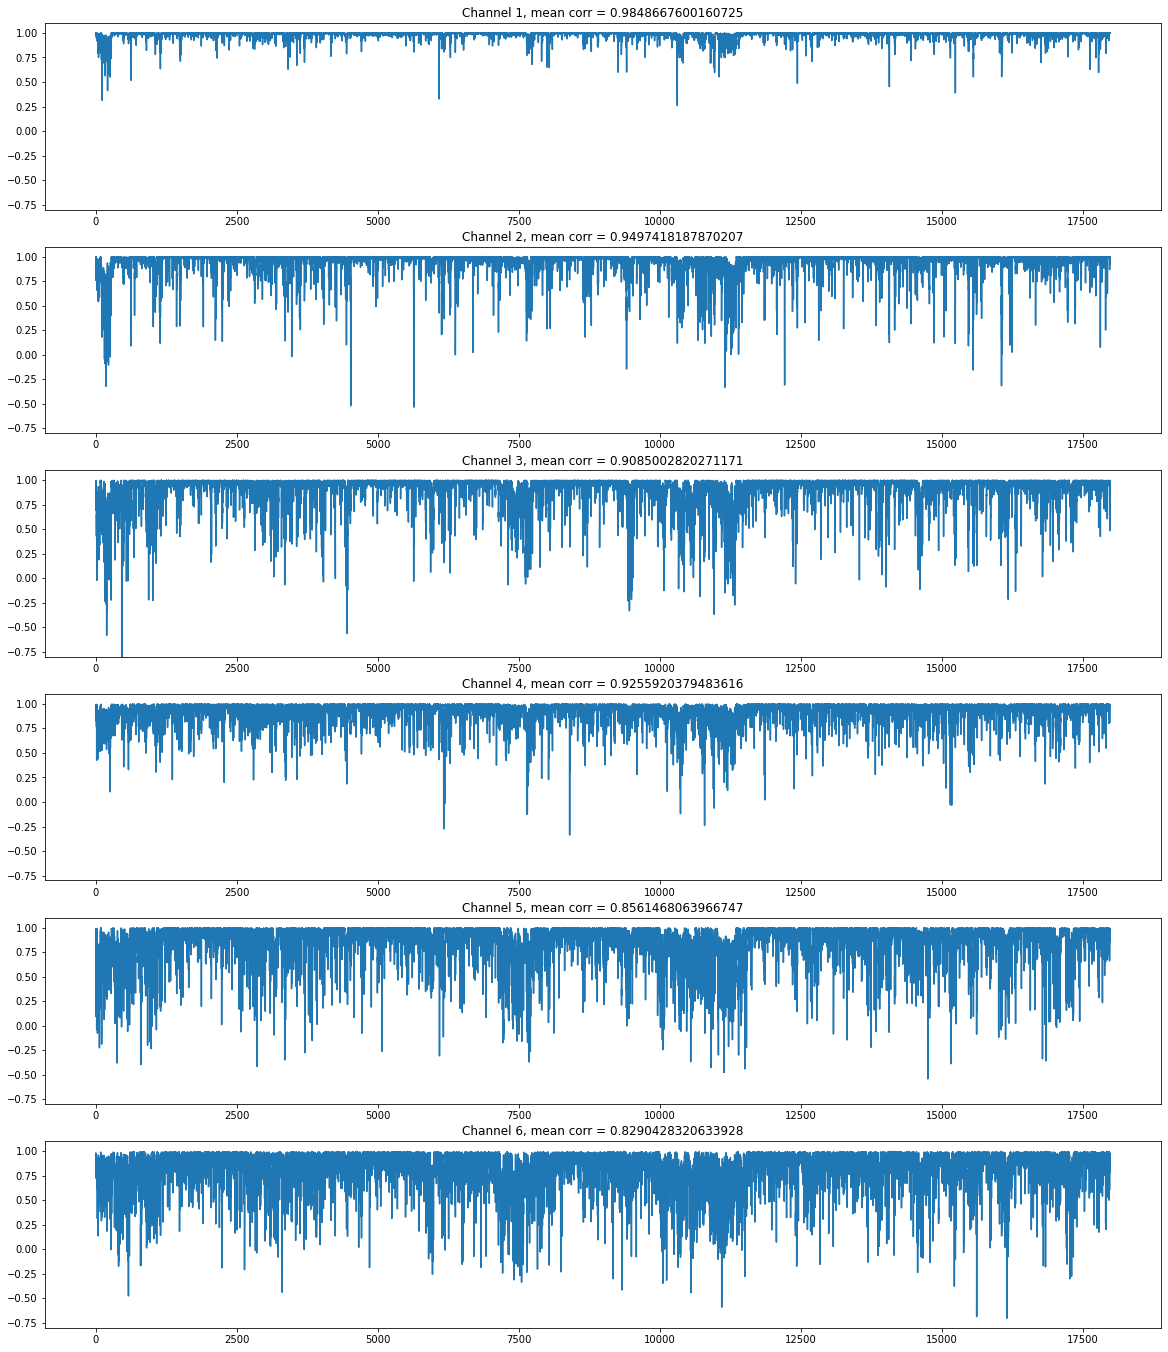

In [424]:
# Plot multiple channels
fig, axs = plt.subplots(number_of_features, 1, figsize = (20, number_of_features*4))
for ii in range(number_of_features):
    axs[ii].plot(corr[ii])
    axs[ii].set_title(f'Channel {ii+1}, mean corr = {np.mean(corr[ii])}')
    axs[ii].set_ylim([-0.8, 1.1])
#     axs[ii].set_xlim([0, 2000])

# # Plot only one channel
# fig, axs = plt.subplots(number_of_features, 1, figsize = (20, 5))
# axs.plot(corr[0])
# axs.set_title(f'Channel {ii+1}, mean corr = {np.mean(corr[0])}')
# axs.set_ylim([-0.8, 1.1])
# # axs.set_xlim([0, 2000])

In [415]:
from sklearn.metrics import mean_squared_error as mse

mse_all = []
mean_all = []
for ii in range(number_of_features):
    mse_channel = []
    mean_channel = []
    for jj in range(X_train.shape[0]):
        ori = X_train[jj, :, ii]
        rec = reconstruction[jj, :, ii]
        mean_seq = np.mean(ori)
        mse_seq = mse(ori, rec)
        mse_channel.append(mse_seq)
        mean_channel.append(mean_seq)
    mse_channel = np.array(mse_channel)
    mean_channel = np.array(mean_channel)
    #print(ii)
    mse_all.append(mse_channel)
    mean_all.append(mean_channel)

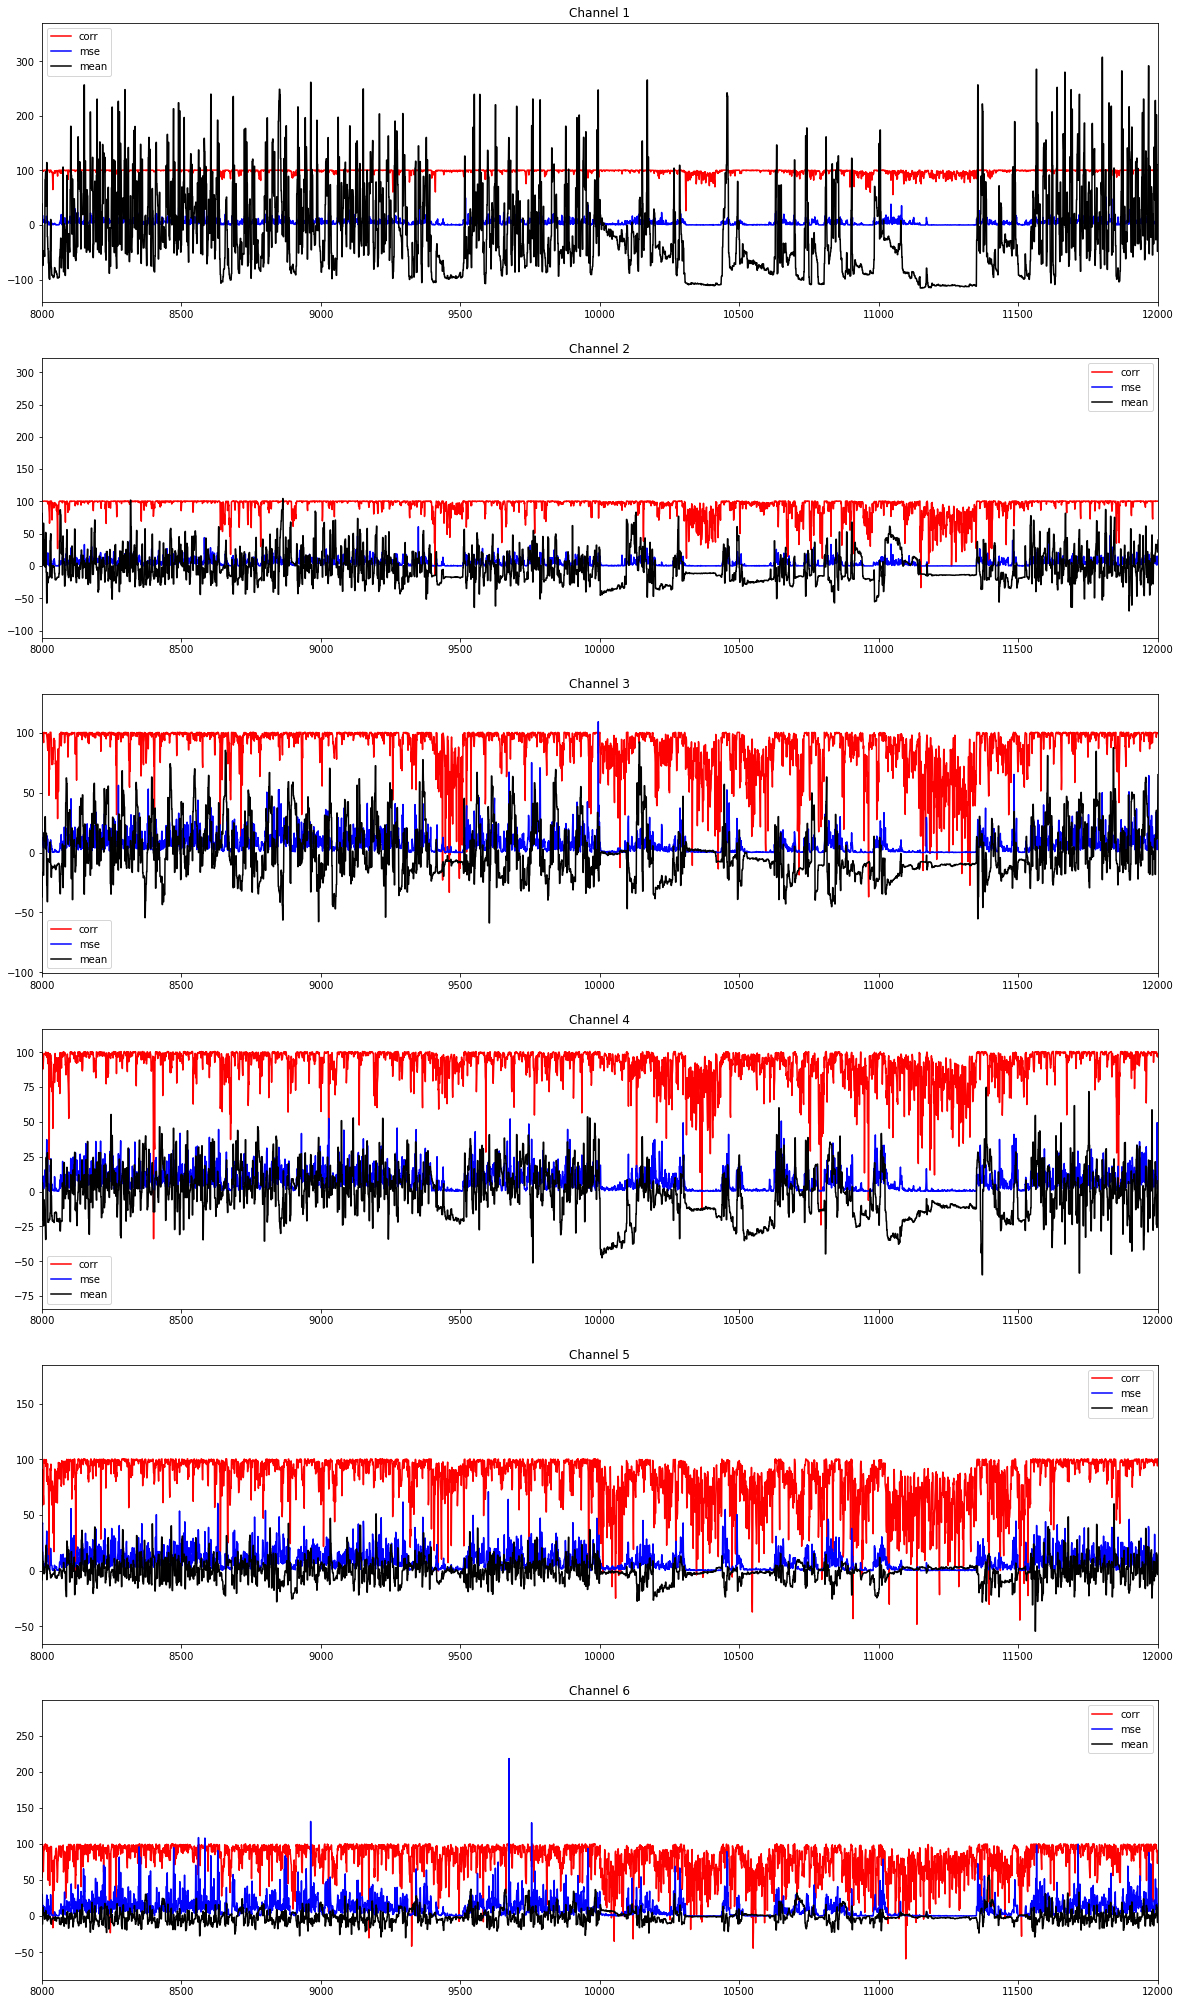

In [422]:
times = np.max(mse_all)
nn = 1000

# Plot multiple channels
fig, axs = plt.subplots(number_of_features, 1, figsize = (20, number_of_features*6))
for ii in range(number_of_features):
    temp = np.array(corr[ii])*times/3
    axs[ii].plot(temp, color = 'r', label = 'corr')
    axs[ii].plot(mse_all[ii], color = 'b', label = 'mse')
    axs[ii].plot(mean_all[ii], color = 'k', label = 'mean')
    axs[ii].set_title(f'Channel {ii+1}')
    axs[ii].set_xlim([8000, 12000])
    axs[ii].legend()
    
# # Plot only one channel
# fig, axs = plt.subplots(number_of_features, 1, figsize = (20, 5))
# axs.plot(corr[0][:nn], color = 'r', label = 'corr')
# axs.plot(mse_all[0][:nn], color = 'b', label = 'mse')
# axs.plot(mean_all[0][:nn], color = 'k', label = 'mean')
# axs.set_title(f'Channel {single_channel}')
# axs.legend()
# # axs.set_xlim([0, 2000])

## Reconstruction of original track if using PCA

In [510]:
temp = reconstruction.reshape(-1, 6)
reconstruction_trace = X_pca.inverse_transform(temp)
reconstruction_trace = reconstruction_trace.reshape(-1, seq_len, 15)

In [458]:
X_train_ori.shape

(44960, 10, 6)

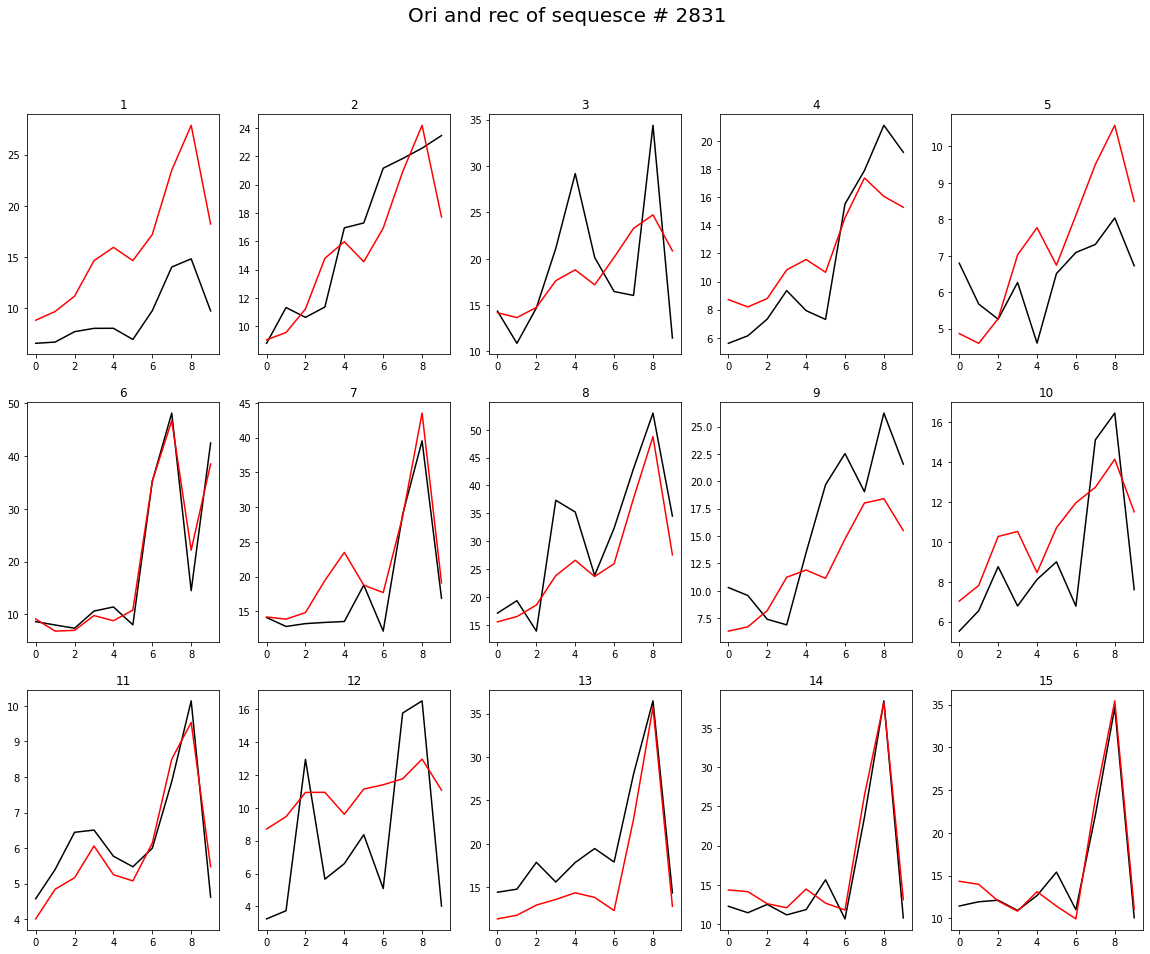

In [511]:
# Show one reconstruction

num_seq = reconstruction_trace.shape[0]

fig, axs = plt.subplots(3, 5, figsize = (20, 15))
# idx = np.random.choice(num_seq, 1)[0]
idx = 2830

for ii in range(15):
    ori = X_train_ori[idx, :, ii]
    rec = reconstruction_trace[idx, :, ii]
    axs[ii//5, ii%5].plot(ori, color = 'black')
    axs[ii//5, ii%5].plot(rec, color = 'red')
    axs[ii//5, ii%5].set_title(ii+1)
fig.suptitle(f'Ori and rec of sequesce # {idx+1}', size = 20)
plt.show()

In [475]:
corr = []
# num_seq
for ii in range(15):
    temp = []
    for jj in range(num_seq):
        corr_temp = np.corrcoef(reconstruction_trace[jj, :, ii], X_train_ori[jj, :, ii])[0,1]
        temp.append(corr_temp)
    corr.append(temp)

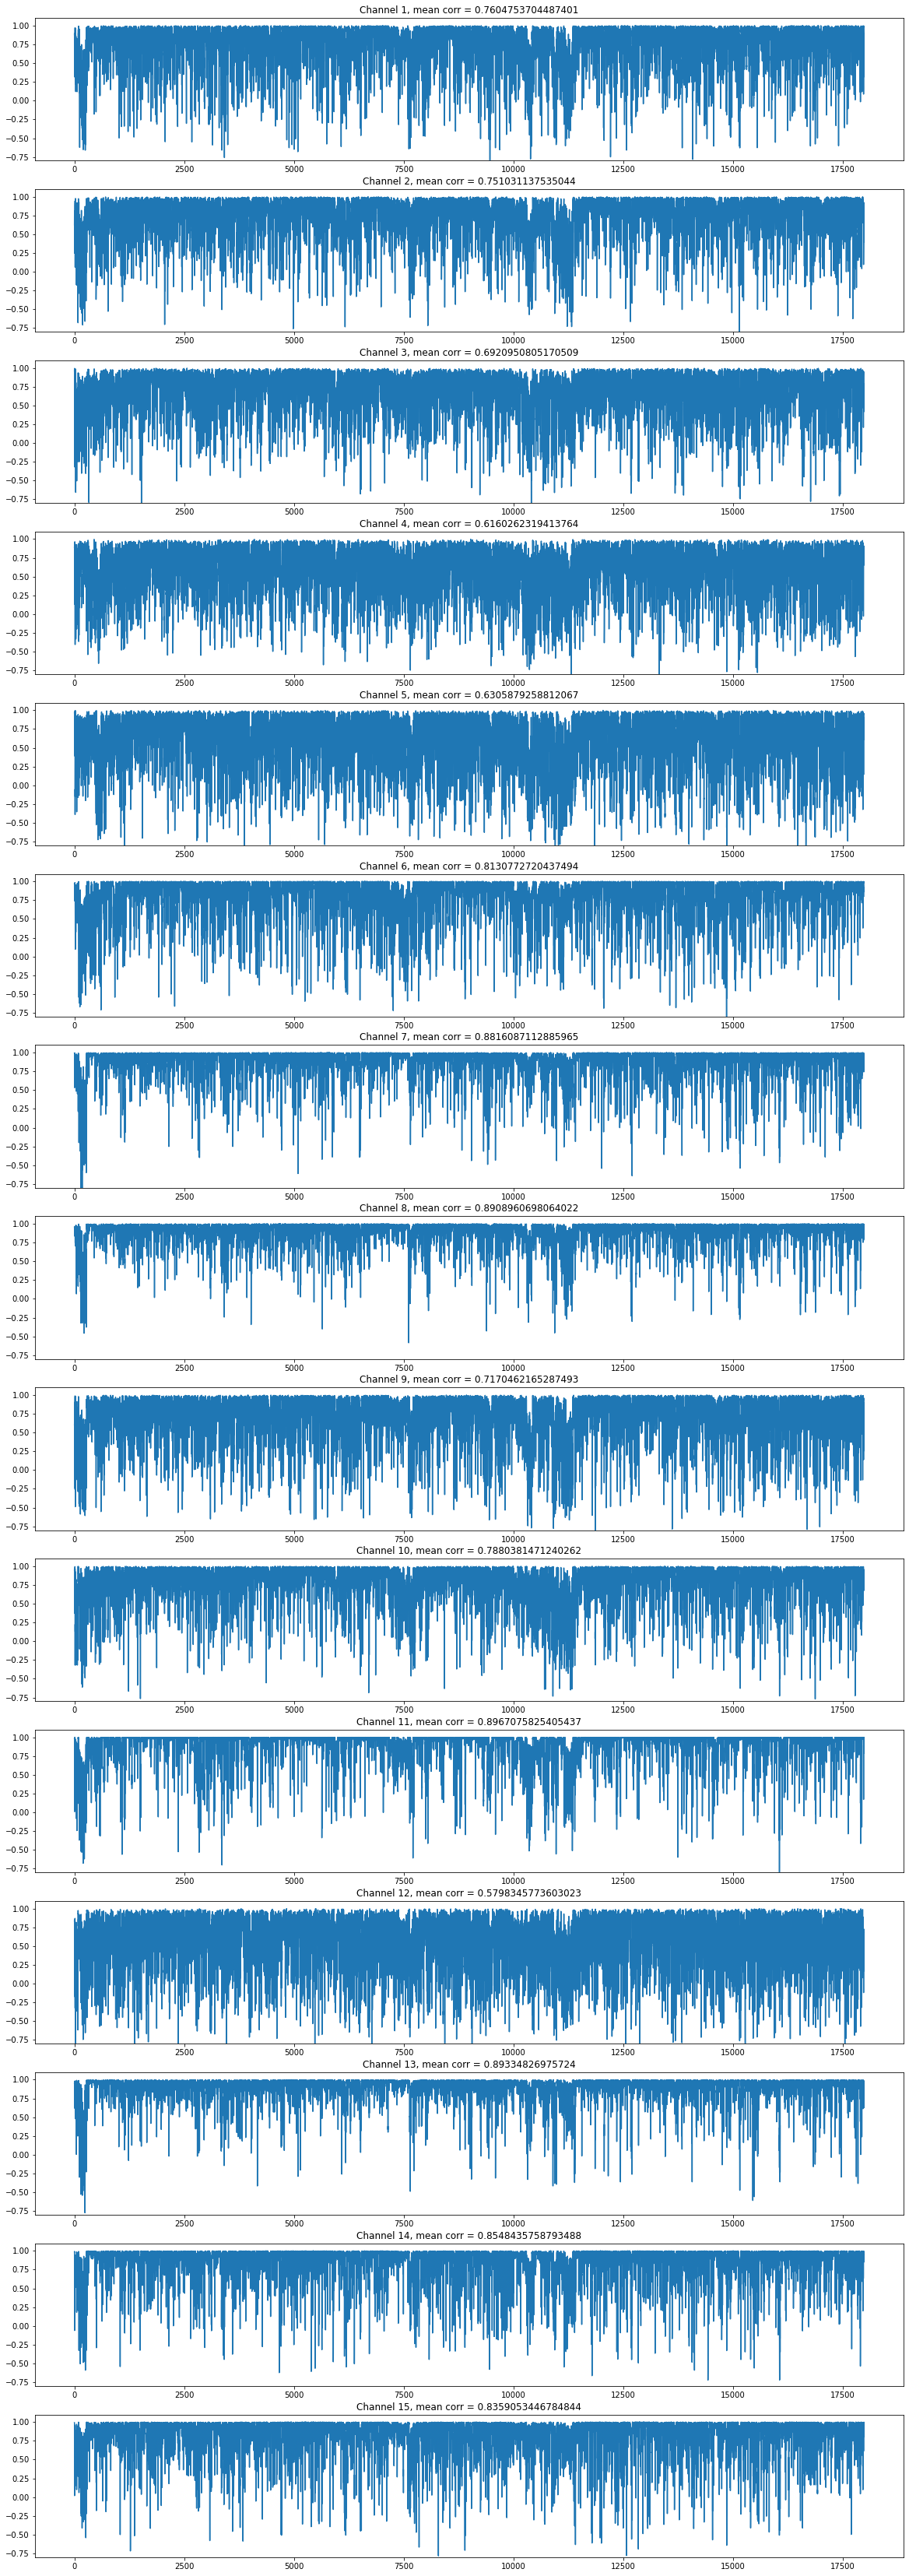

In [476]:
# Plot multiple channels
fig, axs = plt.subplots(15, 1, figsize = (20, 15*4))
for ii in range(15):
    axs[ii].plot(corr[ii])
    axs[ii].set_title(f'Channel {ii+1}, mean corr = {np.mean(corr[ii])}')
    axs[ii].set_ylim([-0.8, 1.1])
#     axs[ii].set_xlim([0, 2000])


In [478]:
from sklearn.metrics import mean_squared_error as mse

mse_all = []
mean_all = []
for ii in range(15):
    mse_channel = []
    mean_channel = []
    for jj in range(X_train_ori.shape[0]):
        ori = X_train_ori[jj, :, ii]
        rec = reconstruction_trace[jj, :, ii]
        mean_seq = np.mean(ori)
        mse_seq = mse(ori, rec)
        mse_channel.append(mse_seq)
        mean_channel.append(mean_seq)
    mse_channel = np.array(mse_channel)
    mean_channel = np.array(mean_channel)
    #print(ii)
    mse_all.append(mse_channel)
    mean_all.append(mean_channel)

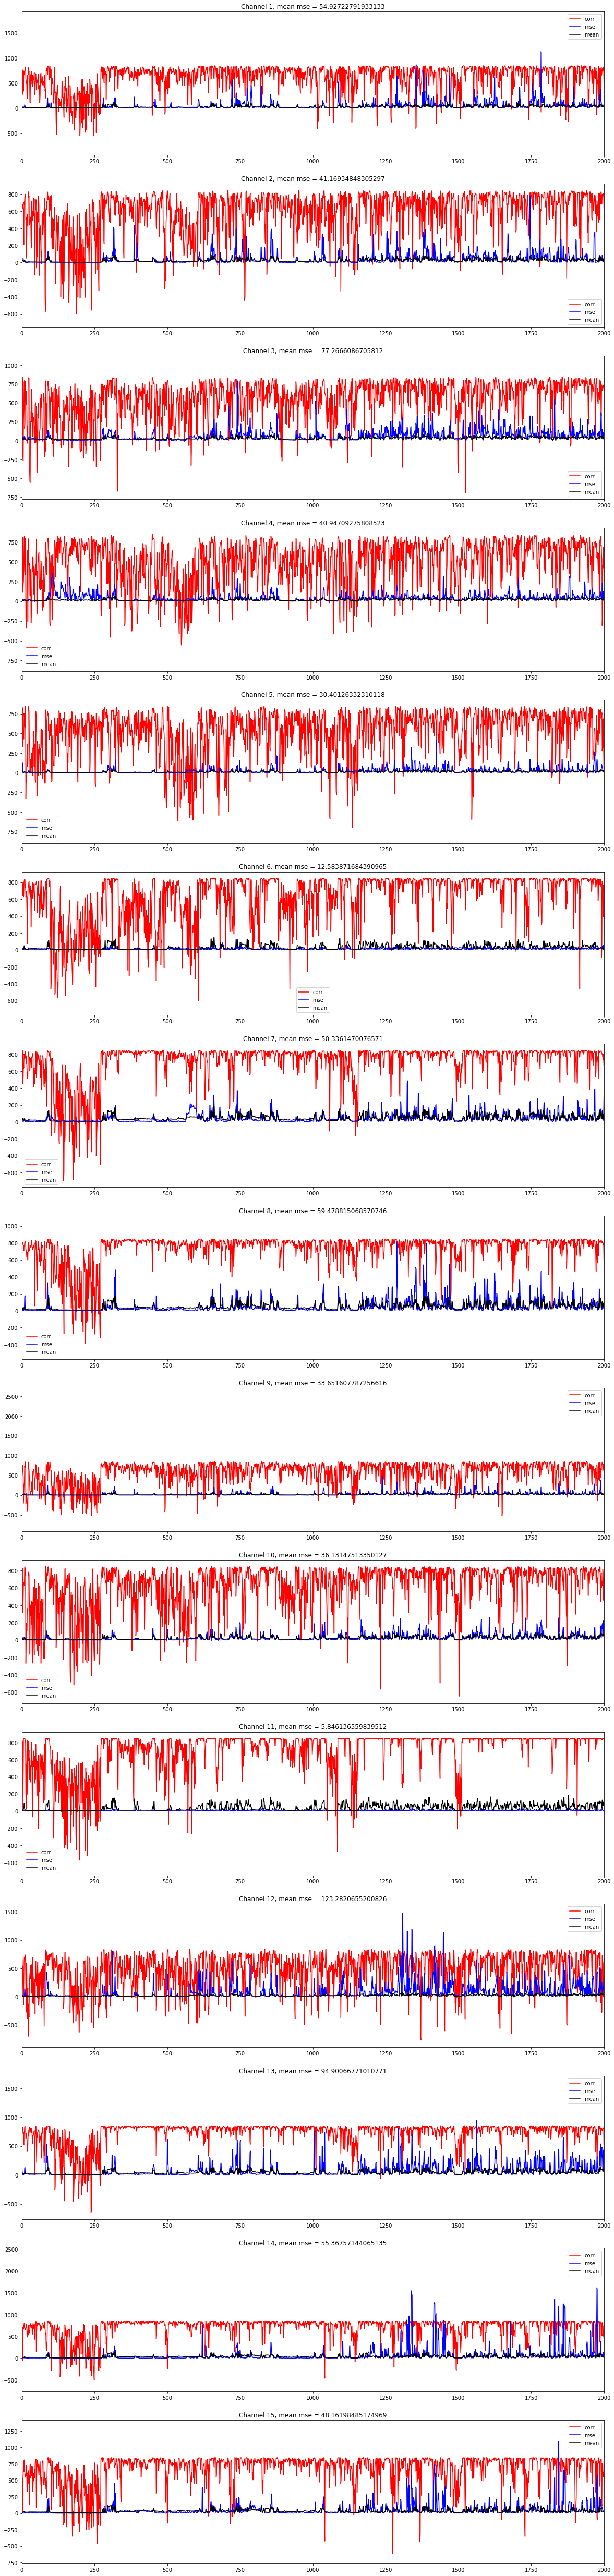

In [480]:
times = np.max(mse_all)
nn = 1000

# Plot multiple channels
fig, axs = plt.subplots(15, 1, figsize = (20, 15*6))
for ii in range(15):
    temp = np.array(corr[ii])*times/3
    axs[ii].plot(temp, color = 'r', label = 'corr')
    axs[ii].plot(mse_all[ii], color = 'b', label = 'mse')
    axs[ii].plot(mean_all[ii], color = 'k', label = 'mean')
    axs[ii].set_title(f'Channel {ii+1}, mean mse = {np.mean(mse_all[ii])}')
    axs[ii].set_xlim([0, 2000])
    axs[ii].legend()

## Reconstruction of test dataset

In [497]:
if do_pca:
    # Copy original training data
    X_test_ori = np.copy(X_test)
#     print(X_train_ori.shape)
    
    # Explained variance
    temp = X_test.reshape(-1, X_test.shape[2])
    X_test_pca = PCA(n_components=6).fit(temp)
#     print(f'Explained variance ratio: {np.cumsum(X_pca.explained_variance_ratio_)}')
    
    # Need to specify N_components inside pca for later reconstruction
#     X_pca = PCA(n_components=6).fit(temp)
    X_test = X_pca.transform(temp)
#     print(f'training dataset shape: {X_train.shape}')
    X_test = X_test.reshape(-1, seq_len, 6)
# print(f'Training dataset shape: {X_train.shape}')
test_dataset = TensorDataset(torch.from_numpy(X_test))

In [512]:
reconstruction = vrae.reconstruct(test_dataset)
reconstruction = reconstruction.transpose((1,0,2))
temp = reconstruction.reshape(-1, 6)
reconstruction_trace = X_test_pca.inverse_transform(temp)
reconstruction_trace = reconstruction_trace.reshape(-1, seq_len, 15)

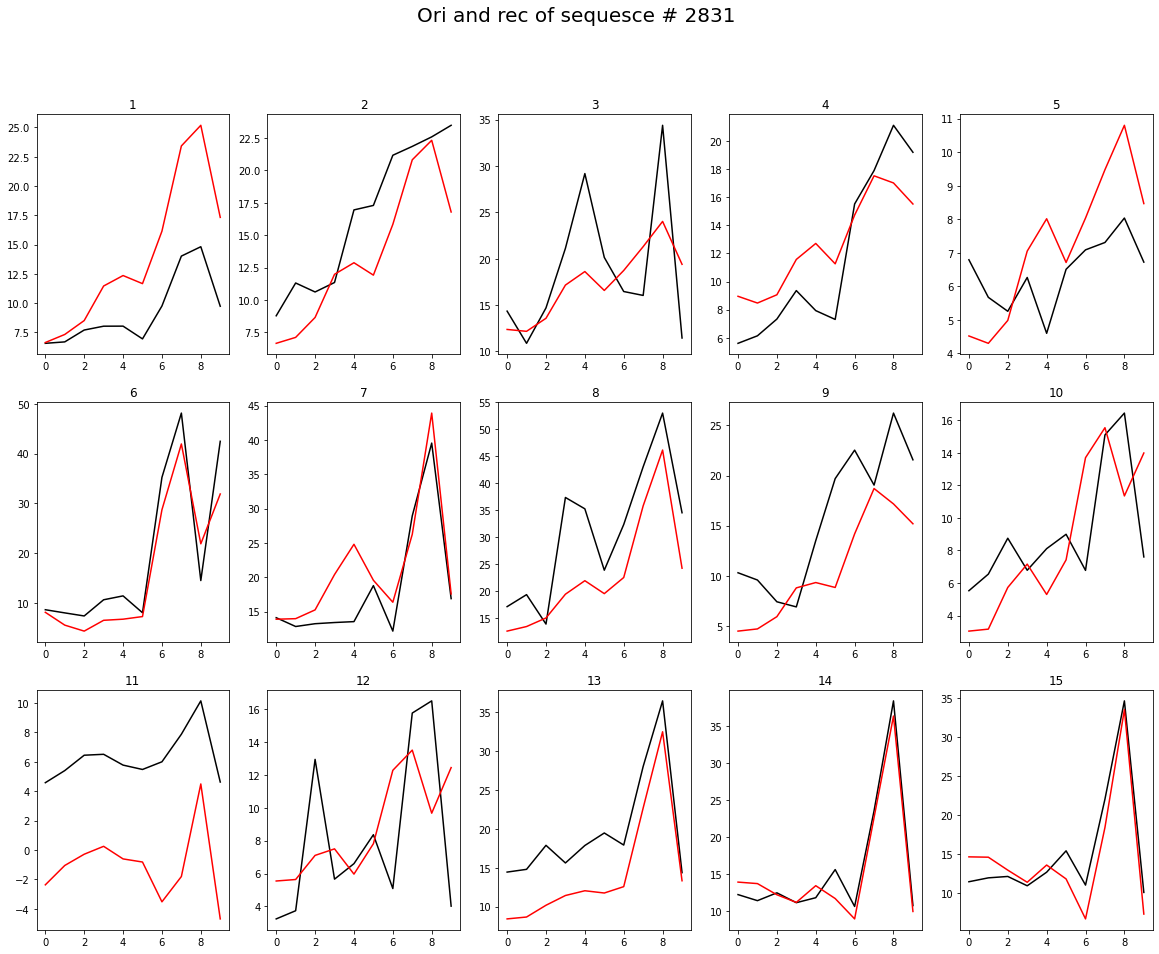

In [508]:
# Show one reconstruction

num_seq = reconstruction_trace.shape[0]

fig, axs = plt.subplots(3, 5, figsize = (20, 15))
idx = np.random.choice(num_seq, 1)[0]
# idx = 250

for ii in range(15):
    ori = X_train_ori[idx, :, ii]
    rec = reconstruction_trace[idx, :, ii]
    axs[ii//5, ii%5].plot(ori, color = 'black')
    axs[ii//5, ii%5].plot(rec, color = 'red')
    axs[ii//5, ii%5].set_title(ii+1)
fig.suptitle(f'Ori and rec of sequesce # {idx+1}', size = 20)
plt.show()

In [515]:
corr = []
num_seq = 3584
for ii in range(15):
    temp = []
    for jj in range(num_seq):
        corr_temp = np.corrcoef(reconstruction_trace[jj, :, ii], X_train_ori[jj, :, ii])[0,1]
        temp.append(corr_temp)
    corr.append(temp)

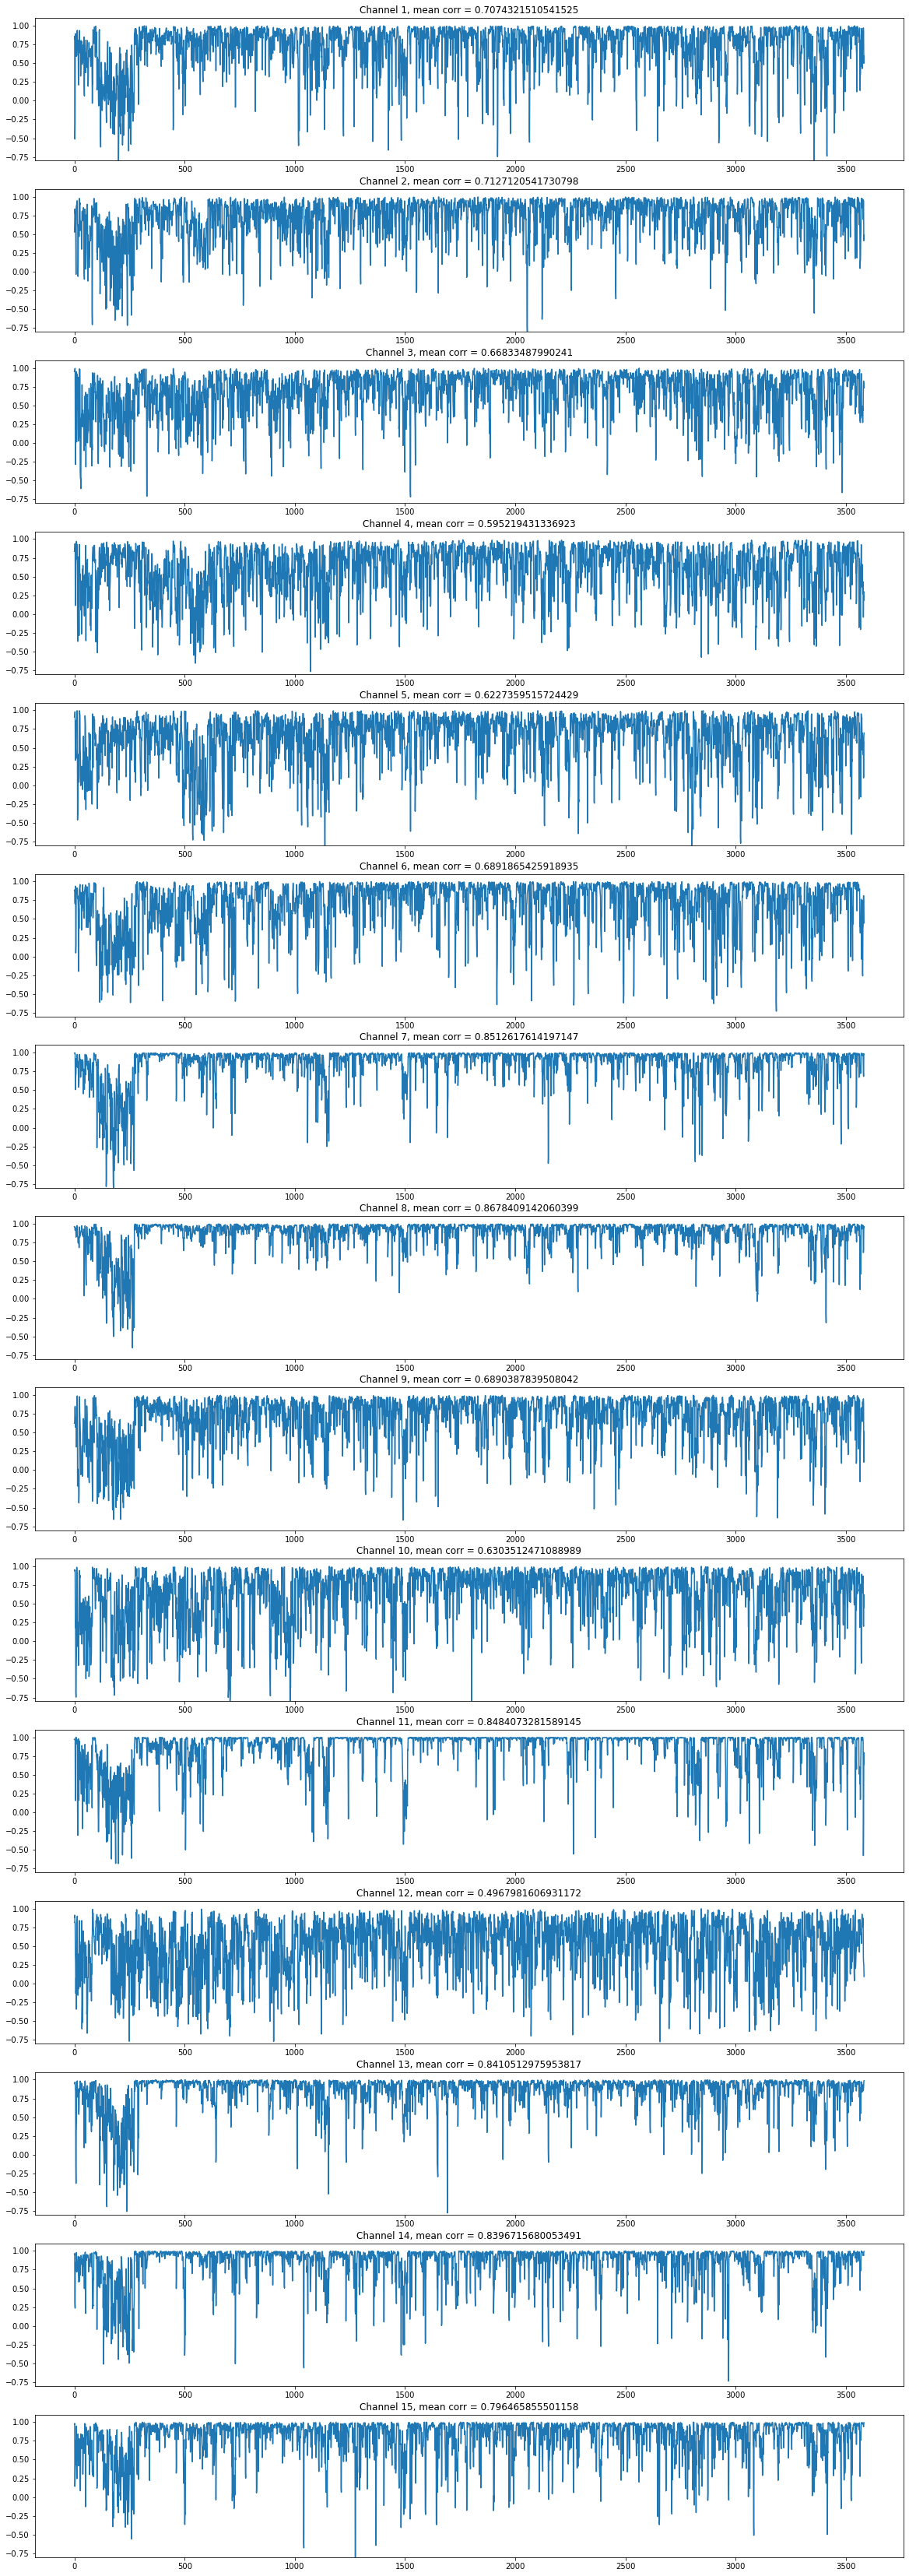

In [516]:
# Plot multiple channels
fig, axs = plt.subplots(15, 1, figsize = (20, 15*4))
for ii in range(15):
    axs[ii].plot(corr[ii])
    axs[ii].set_title(f'Channel {ii+1}, mean corr = {np.mean(corr[ii])}')
    axs[ii].set_ylim([-0.8, 1.1])
#     axs[ii].set_xlim([0, 2000])


### Visualize using PCA and tSNE

In [401]:
bhvs = {'crawling': np.array([0]),
        'high picking treats': np.array([1]),
        'low picking treats': np.array([2]),
        'pg': np.array([3]),
        'sitting still': np.array([4]),
        'grooming': np.array([5]),
        'no_behavior': np.array([-1])}

inv_bhvs = {int(v): k for k, v in bhvs.items()}

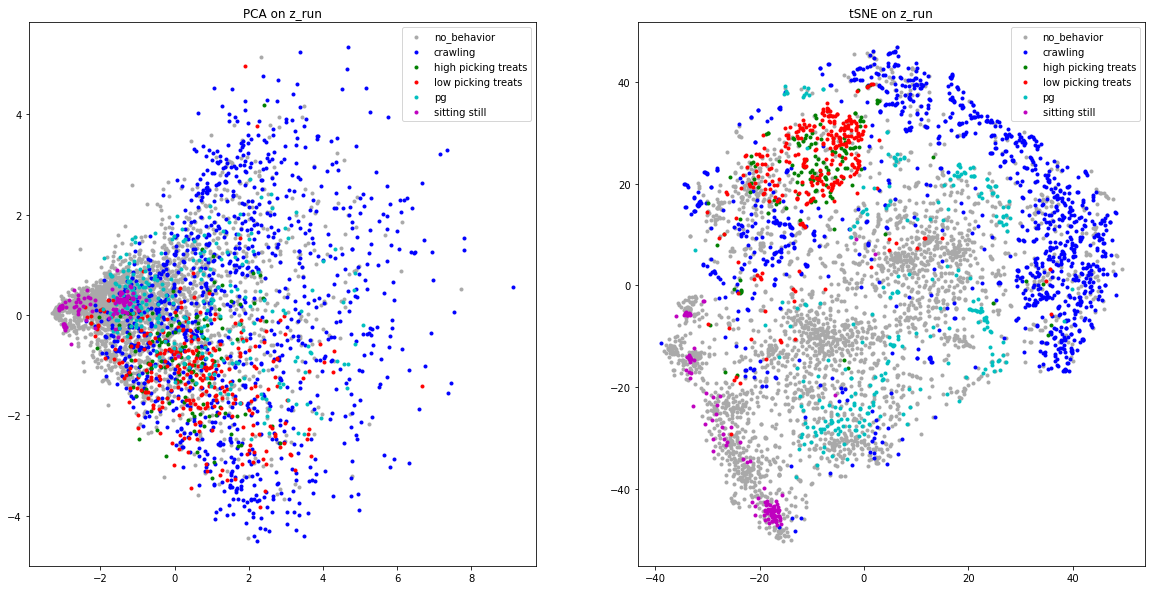

In [403]:
# pick one in four sequence for visulization
z_run_down = z_run[::4, :]
# z_run_pca = TruncatedSVD(n_components=2).fit_transform(z_run_down)
# z_run_pca = PCA(n_components=2).fit_transform(z_run_down)
# z_run_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(z_run_down)

all_colors = ['b','g','r','c','m','y','darkgrey']
label = y_train[::4, :]

fig, axs = plt.subplots(1,2, figsize=(20,10))

for ii in np.unique(label):
    ii = int(ii)
    
    x_pca = z_run_pca[:,0].reshape(-1,1)[label == ii]
    y_pca = z_run_pca[:,1].reshape(-1,1)[label == ii]
    axs[0].scatter(x_pca, y_pca, c=all_colors[ii], marker='.', label = inv_bhvs[ii], linewidths=None)
    
    x_tsne = z_run_tsne[:,0].reshape(-1,1)[label == ii]
    y_tsne = z_run_tsne[:,1].reshape(-1,1)[label == ii]
    axs[1].scatter(x_tsne, y_tsne, c=all_colors[ii], marker='.', label = inv_bhvs[ii], linewidths=None)
    
axs[0].set_title('PCA on z_run')
axs[1].set_title('tSNE on z_run')
axs[0].legend()
axs[1].legend()
plt.show()

In [518]:
z_run_test = vrae.transform(test_dataset, save = False)


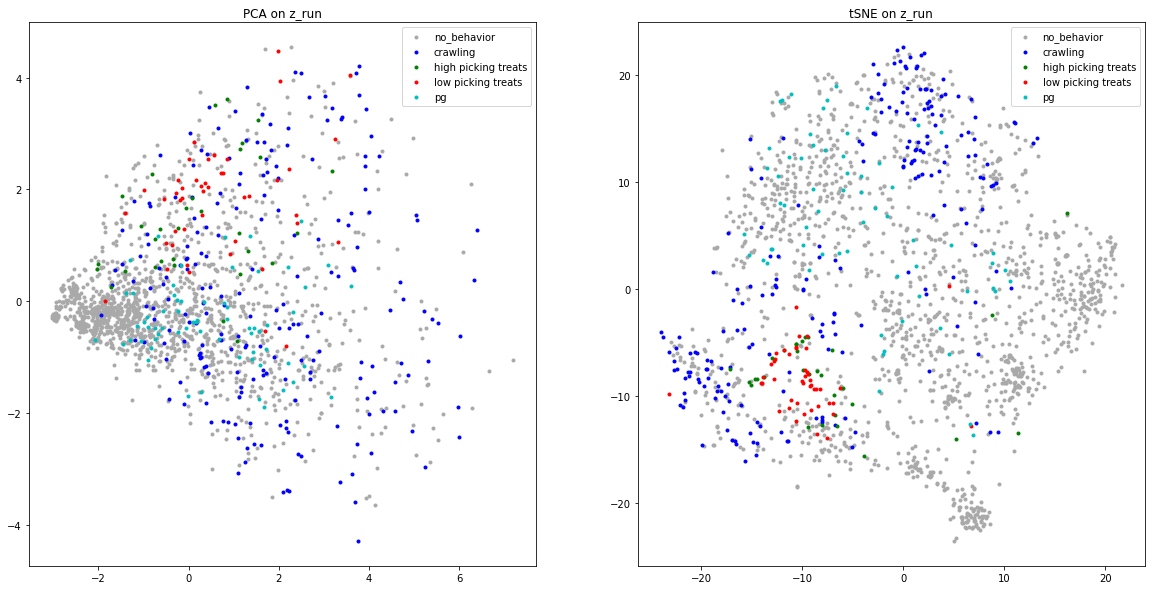

In [520]:
# pick one in four sequence for visulization
z_run_down = z_run_test[::2, :]
# z_run_pca = TruncatedSVD(n_components=2).fit_transform(z_run_down)
z_run_pca = PCA(n_components=2).fit_transform(z_run_down)
z_run_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(z_run_down)

all_colors = ['b','g','r','c','m','y','darkgrey']
label = y_test[::2, :][:1792]

fig, axs = plt.subplots(1,2, figsize=(20,10))

for ii in np.unique(label):
    ii = int(ii)
    
    x_pca = z_run_pca[:,0].reshape(-1,1)[label == ii]
    y_pca = z_run_pca[:,1].reshape(-1,1)[label == ii]
    axs[0].scatter(x_pca, y_pca, c=all_colors[ii], marker='.', label = inv_bhvs[ii], linewidths=None)
    
    x_tsne = z_run_tsne[:,0].reshape(-1,1)[label == ii]
    y_tsne = z_run_tsne[:,1].reshape(-1,1)[label == ii]
    axs[1].scatter(x_tsne, y_tsne, c=all_colors[ii], marker='.', label = inv_bhvs[ii], linewidths=None)
    
axs[0].set_title('PCA on z_run')
axs[1].set_title('tSNE on z_run')
axs[0].legend()
axs[1].legend()
plt.show()

In [47]:
# # Create clusters.annot
# from sklearn.mixture import GaussianMixture

# # Predict cluster assignments
# gm = GaussianMixture(n_components=5, random_state=0).fit(z_run)
# clusters = gm.predict(z_run)

# # Number of seconds in each sequence
# filt_time_step = 0.025
# num_secs_seq = sequence_length * filt_time_step
# end_time = len(z_run) * num_secs_seq + num_secs_seq

# # Print head of the file
# f = open ('Pop01-06_18_2021.annot','w')
# # write the header--------------------
# f.write('Bento annotation file\n')
# f.write('Movie file(s): {}\n\n'.format('Pop_20210618_cage_C1_01.avi'))
# f.write('{0} {1}\n'.format('Stimulus name:',''))
# f.write('{0} {1}\n'.format('Annotation start frame:',1))
# f.write('{0} {1}\n'.format('Annotation stop frame:', 26994))
# f.write('{0} {1}\n'.format('Annotation framerate:', 30))

# f.write('\n{0}\n'.format('List of channels:'))
# channels = ['cluster_num']
# for item in channels:
#         f.write('{0}\n'.format(item))
# f.write('\n');

# f.write('{0}\n'.format('List of annotations:'))
# clust_names = ['cluster_{}'.format(str(num)) for num in set(clusters)]
# labels = clust_names
# # labels = [item.replace(' ','_') for item in labels]
# for item in labels:
#     f.write('{0}\n'.format(item))
# f.write('\n')

# # now write the contents---------------
# for ch in channels:
#     f.write('{0}----------\n'.format(ch))
#     for beh in labels:
#         f.write('>{0}\n'.format(beh))
#         f.write('{0}\t {1}\t {2} \n'.format('Start','Stop','Duration'))

#         idxs = np.where(clusters == int(beh.split('_')[-1]))[0]
#         for hit in idxs:
#             start_time = hit * num_secs_seq/2
#             end_time = start_time + num_secs_seq
#             f.write('{0}\t{1}\t{2}\n'.format(start_time, end_time, num_secs_seq))
#         f.write('\n')
#     f.write('\n')

# f.close()